# Canonical Issue Data Exploration and Visualization
This notebook performs EDA on the `issues dataframe` generated during the `issues_preprocessing.ipynb` step.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read the parquet file as a dataframe
issues_df = pd.read_parquet("../../data/data_preparation/issues_preprocessed.parquet.gzip")

Granularity of the dataframe: `journal` > `issues` > `pages` > `content items (ci)`

In [3]:
print(f"There are {len(issues_df):,} rows in the dataframe.")

There are 14,872,217 rows in the dataframe.


In [4]:
issues_df.sample(5)

,id,cdt,pp,iiif_manifest_uri,ci_id,ci_tp,ci_t,ci_l,ci_ro,ci_img_bbx,journal,date
497822,lematin-1898-03-15-a,2024-03-27 23:51:32,lematin-1898-03-15-a-p0001,https://gallica.bnf.fr/iiif/ark:/12148/bpt6k55...,lematin-1898-03-15-a-i0011,article,Informations LE POURVOI ZOLA,fr,11,None,lematin,1898-03-15
200724,obermosel-1934-08-04-c,2024-03-01 18:59:47,obermosel-1934-08-04-c-p0008,None,obermosel-1934-08-04-c-i0032,article,Der Tod auf Hohenfried.,None,27,None,obermosel,1934-08-04
996911,oecaen-1913-04-04-a,2024-02-27 23:57:01,oecaen-1913-04-04-a-p0002,https://gallica.bnf.fr/iiif/ark:/12148/bpt6k49...,oecaen-1913-04-04-a-i0029,article,None,fr,36,None,oecaen,1913-04-04
52499,oeuvre-1939-06-22-a,2024-02-26 09:39:56,oeuvre-1939-06-22-a-p0008,https://gallica.bnf.fr/iiif/ark:/12148/bpt6k46...,oeuvre-1939-06-22-a-i0130,article,Literie,None,187,None,oeuvre,1939-06-22
89799,legaulois-1889-04-07-a,2024-03-27 20:46:51,legaulois-1889-04-07-a-p0003,https://gallica.bnf.fr/iiif/ark:/12148/bpt6k52...,legaulois-1889-04-07-a-i0034,ad,Adv. 7 Page 3,None,29,None,legaulois,1889-04-07


### Preliminary dataframe cleaning check

In [5]:
len(issues_df), len(issues_df.drop_duplicates(subset=["pp", "ci_id"]))

(14872217, 14872217)

--> Looks like we only have unique pairs of 'page - content item' in the dataframe. We don't need to drop any duplicates.

### Basic counts

In [6]:
print(f"""
There are:
    - {len(set(issues_df["journal"]))} Journals
    - {len(set(issues_df["id"])):,} unique Issues
    - {len(set(issues_df["pp"])):,} unique Pages
    - {len(set(issues_df["ci_id"])):,} unique Content Items 
    - {len(set(issues_df["ci_l"]))} detected Languages: {list(set(issues_df["ci_l"]))}
in the dataframe.
""")


There are:
    - 37 Journals
    - 220,947 unique Issues
    - 1,142,515 unique Pages
    - 14,368,624 unique Content Items 
    - 9 detected Languages: [None, 'fi', 'lb', 'da', 'fr', 'de', 'pt', 'nl', 'en']
in the dataframe.



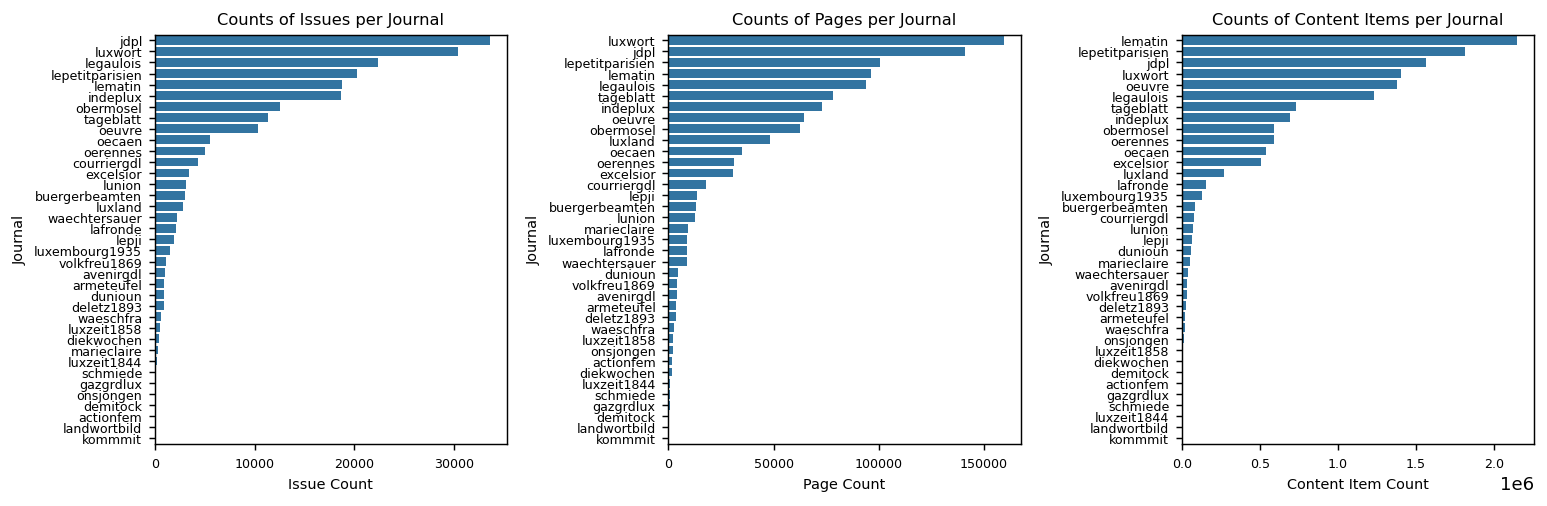

In [7]:
# Define a reusable function for generating bar plots
def create_barplot(dataframe, subset_column, group_column, value_column, xlabel, title, figsize=(3, 4), dpi=130):
    counts = (
        dataframe.drop_duplicates(subset=subset_column)
        .groupby(group_column)[subset_column]
        .count()
        .reset_index(name=value_column)
        .sort_values(by=value_column, ascending=False)
    )
    sns.barplot(
        data=counts, 
        y=group_column, 
        x=value_column, 
        order=counts[group_column]
    )
    plt.xlabel(xlabel, fontsize=8)
    plt.ylabel(group_column.capitalize(), fontsize=8)
    plt.title(title, fontsize=9)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

# Prepare the figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=130)

# Map the plots to the respective columns and titles
plots = [
    ("id", "Issue Count", "Counts of Issues per Journal"),
    ("pp", "Page Count", "Counts of Pages per Journal"),
    ("ci_id", "Content Item Count", "Counts of Content Items per Journal"),
]

for ax, (subset_column, xlabel, title) in zip(axes, plots):
    plt.sca(ax)  # Set current axis
    create_barplot(
        issues_df, 
        subset_column=subset_column, 
        group_column="journal", 
        value_column="count", 
        xlabel=xlabel, 
        title=title
    )

plt.tight_layout()
plt.show()

### Monthly Publication Frequency of Issues

In [8]:
# set month, year, decade
issues_df["month"] = issues_df["date"].dt.to_period("M")
issues_df["year"] = issues_df["date"].dt.year
issues_df["decade"] = (issues_df["year"] // 10) * 10

In [9]:
# min, max, and median number of issues published per month for each journal
issues_per_month = (
    issues_df.drop_duplicates(subset=["id"]).reset_index(drop=True).groupby(["journal", "month"])["id"]
    .nunique()  # count unique issues per month
    .reset_index(name="issues_per_month")
)

issues_stats = (
    issues_per_month.groupby("journal")["issues_per_month"]
    .agg(["min", "max", "median"])
    .reset_index()
    .rename(columns={"min": "min_issues_per_month", "max": "max_issues_per_month", "median": "median_issues_per_month"})
    .sort_values(["median_issues_per_month"], ascending=False)
    .reset_index(drop=True)
)
issues_stats

,journal,min_issues_per_month,max_issues_per_month,median_issues_per_month
0,lematin,1,62,31.0
1,legaulois,9,59,31.0
2,lepetitparisien,8,36,30.0
3,jdpl,1,83,30.0
4,oerennes,1,31,30.0
5,oeuvre,2,47,30.0
6,excelsior,10,35,30.0
7,oecaen,2,32,29.0
8,luxwort,2,49,26.0
9,lafronde,1,35,26.0


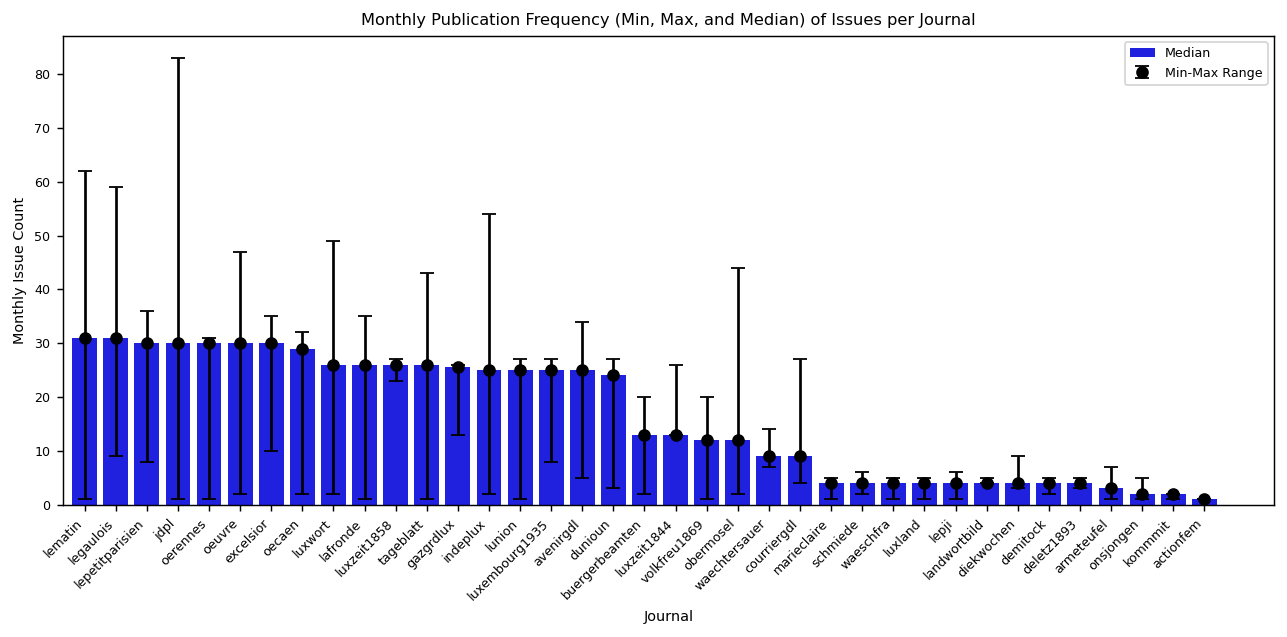

In [10]:
plt.figure(figsize=(10, 5), dpi=130)

# Create a vertical bar plot with the median values
sns.barplot(
    data=issues_stats,
    x="journal",
    y="median_issues_per_month",
    order=issues_stats["journal"],
    color="blue",  # Color for median bars
    label="Median"
)

# Add error bars for min and max
for index, row in issues_stats.iterrows():
    plt.errorbar(
        x=index,  # Corresponding x position for the journal
        y=row["median_issues_per_month"],
        yerr=[[row["median_issues_per_month"] - row["min_issues_per_month"]], 
              [row["max_issues_per_month"] - row["median_issues_per_month"]]],  # Asymmetric error bars
        fmt="o",  # Marker type
        color="black",  # Error bar color
        capsize=4,  # End cap size
        label="Min-Max Range" if index == 0 else ""  # Avoid duplicate legend entries
    )

# Customize plot labels and title
plt.ylabel("Monthly Issue Count", fontsize=8)
plt.xlabel("Journal", fontsize=8)
plt.title("Monthly Publication Frequency (Min, Max, and Median) of Issues per Journal", fontsize=9)
plt.xticks(fontsize=7, rotation=45, ha="right")  # Rotate journal labels for better visibility
plt.yticks(fontsize=7)
plt.xlim(xmin=-0.7)

# Add a legend
plt.legend(fontsize=7, title_fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()

### Number of Pages per Issue

In [11]:
# min, max, and median number of pages in an issue for each journal
pages_per_issue = (
    issues_df.drop_duplicates(subset=["pp"]).reset_index(drop=True).groupby(["journal", "id"])["pp"]
    .nunique()  # count unique pages per issue
    .reset_index(name="pages_per_issue")
)

pages_stats = (
    pages_per_issue.groupby("journal")["pages_per_issue"]
    .agg(["min", "max", "median"])
    .reset_index()
    .rename(columns={"min": "min_pages_per_issue", "max": "max_pages_per_issue", "median": "median_pages_per_issue"})
    .sort_values(["median_pages_per_issue"], ascending=False)
    .reset_index(drop=True)
)
pages_stats

,journal,min_pages_per_issue,max_pages_per_issue,median_pages_per_issue
0,marieclaire,1,80,29.0
1,actionfem,2,28,20.0
2,luxland,4,76,16.0
3,onsjongen,2,40,16.0
4,excelsior,4,16,10.0
5,landwortbild,4,14,8.0
6,kommmit,8,16,8.0
7,lepji,2,16,8.0
8,oerennes,2,24,6.0
9,oeuvre,1,12,6.0


In [22]:
counts = (
    issues_df.drop_duplicates(subset="id")
    .groupby("journal")[subset_column]
    .count()
    .reset_index(name="issue_count")
    .sort_values(by="issue_count", ascending=False)
    .reset_index(drop=True)
)

pages_stats = pages_stats.merge(counts, on="journal")
pages_stats

,journal,min_pages_per_issue,max_pages_per_issue,median_pages_per_issue,issue_count
0,marieclaire,1,80,29.0,309
1,actionfem,2,28,20.0,101
2,luxland,4,76,16.0,2772
3,onsjongen,2,40,16.0,139
4,excelsior,4,16,10.0,3402
5,landwortbild,4,14,8.0,39
6,kommmit,8,16,8.0,22
7,lepji,2,16,8.0,1880
8,oerennes,2,24,6.0,5017
9,oeuvre,1,12,6.0,10309


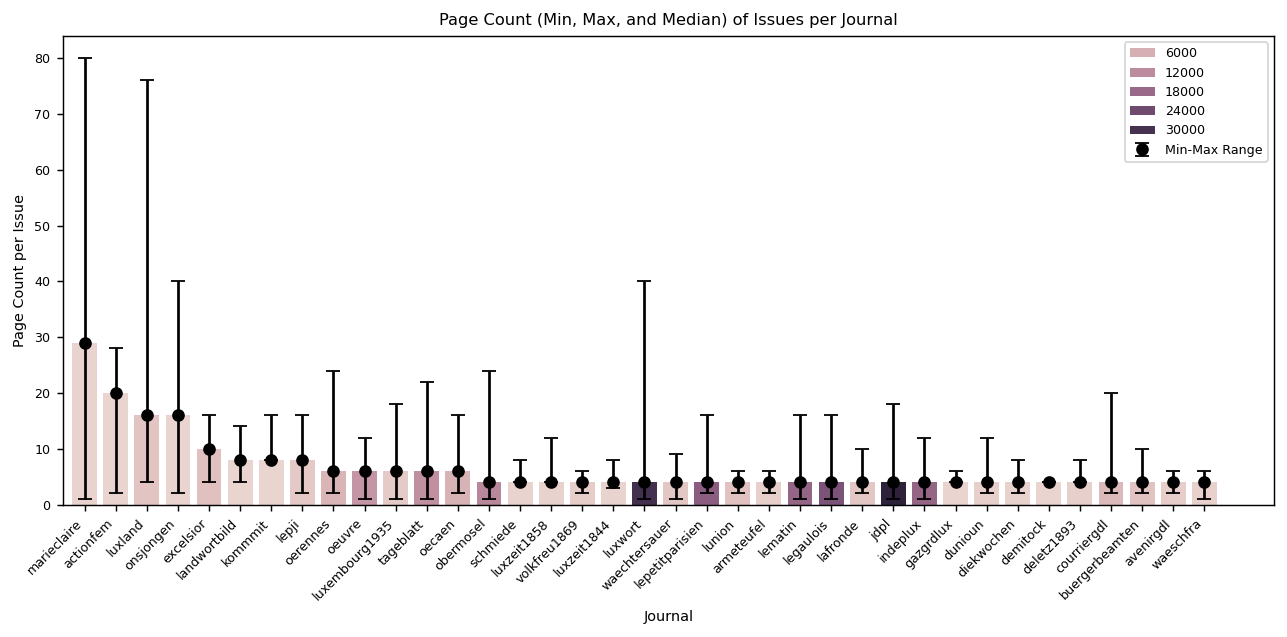

In [28]:
plt.figure(figsize=(10, 5), dpi=130)

# Create a vertical bar plot with the median values
sns.barplot(
    data=pages_stats,
    x="journal",
    y="median_pages_per_issue",
    order=pages_stats["journal"],
    #color="blue",  # Color for median bars
    hue="issue_count"
)

# Add error bars for min and max
for index, row in pages_stats.iterrows():
    plt.errorbar(
        x=index,  # Corresponding x position for the journal
        y=row["median_pages_per_issue"],
        yerr=[[row["median_pages_per_issue"] - row["min_pages_per_issue"]], 
              [row["max_pages_per_issue"] - row["median_pages_per_issue"]]],  # Asymmetric error bars
        fmt="o",  # Marker type
        color="black",  # Error bar color
        capsize=4,  # End cap size
        label="Min-Max Range" if index == 0 else ""  # Avoid duplicate legend entries
    )

# Customize plot labels and title
plt.ylabel("Page Count per Issue", fontsize=8)
plt.xlabel("Journal", fontsize=8)
plt.title("Page Count (Min, Max, and Median) of Issues per Journal", fontsize=9)
plt.xticks(fontsize=7, rotation=45, ha="right")  # Rotate journal labels for better visibility
plt.yticks(fontsize=7)
plt.xlim(xmin=-0.7)

# Add a legend
plt.legend(fontsize=7, title_fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()


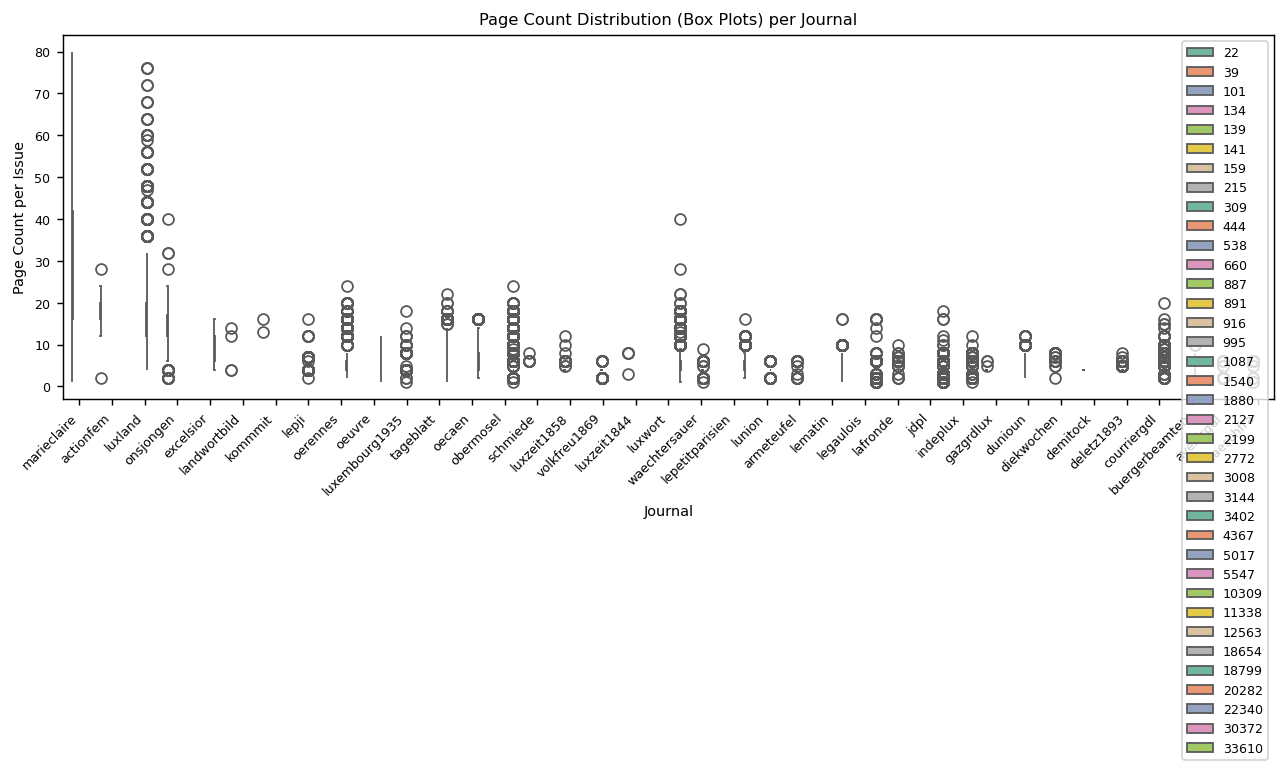

In [41]:
plt.figure(figsize=(10, 5), dpi=130)

# Create box plots for the data
sns.boxplot(
    data=pages_per_issue.merge(counts, on="journal"),
    x="journal",
    y="pages_per_issue",
    hue="issue_count",  # Group by issue count if desired
    order=pages_stats["journal"],
    palette="Set2",  # Adjust color palette for better visualization
    dodge=True  # Separate groups in the same category
)

# Customize plot labels and title
plt.ylabel("Page Count per Issue", fontsize=8)
plt.xlabel("Journal", fontsize=8)
plt.title("Page Count Distribution (Box Plots) per Journal", fontsize=9)
plt.xticks(fontsize=7, rotation=45, ha="right")  # Rotate journal labels for better visibility
plt.yticks(fontsize=7)

# Adjust the legend
plt.legend(fontsize=7, title_fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()

### Timeframe/Timewindow of a Journal

In [13]:
# Timeframe/Timewindow of a journal
timeframes = (
    issues_df.drop_duplicates(subset=["id"]).groupby("journal")["date"]
    .agg(["min", "max"])
    .reset_index()
    .rename(columns={"min": "start_date", "max": "end_date"})
)
timeframes["time_window_years"] = (timeframes["end_date"] - timeframes["start_date"]).dt.days / 365
timeframes = timeframes.sort_values(["time_window_years"], ascending=False).reset_index(drop=True)
timeframes

,journal,start_date,end_date,time_window_years
0,jdpl,1814-04-01,1944-08-19,130.471233
1,luxwort,1848-03-23,1950-12-30,102.838356
2,lepetitparisien,1876-10-15,1944-08-17,67.882192
3,obermosel,1881-06-18,1948-04-03,66.835616
4,indeplux,1871-10-01,1934-12-31,63.290411
5,legaulois,1868-07-05,1929-03-30,60.772603
6,lematin,1884-02-26,1942-12-31,58.882192
7,luxland,1954-01-01,2007-12-21,54.005479
8,oerennes,1899-08-03,1942-12-31,43.438356
9,tageblatt,1913-06-30,1950-12-30,37.526027


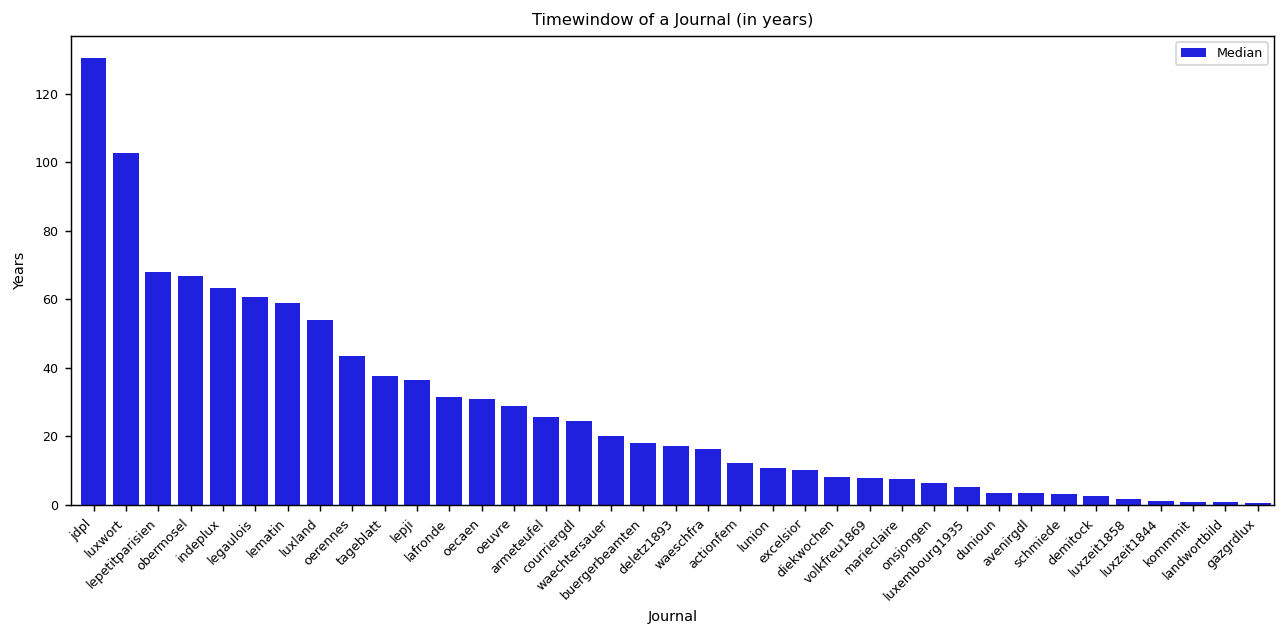

In [14]:
plt.figure(figsize=(10, 5), dpi=130)

# Create a vertical bar plot with the median values
sns.barplot(
    data=timeframes,
    x="journal",
    y="time_window_years",
    order=timeframes["journal"],
    color="blue",  # Color for median bars
    label="Median"
)

# Customize plot labels and title
plt.ylabel("Years", fontsize=8)
plt.xlabel("Journal", fontsize=8)
plt.title("Timewindow of a Journal (in years)", fontsize=9)
plt.xticks(fontsize=7, rotation=45, ha="right")  # Rotate journal labels for better visibility
plt.yticks(fontsize=7)
plt.xlim(xmin=-0.7)

# Add a legend
plt.legend(fontsize=7, title_fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()

### Number of journals

In [9]:
print(f"There are {len(set(issues_df["journal"]))} journals in the data.")

There are 37 journals in the data.


### Language of journals

In [25]:
issues_df["ci_l"].value_counts(dropna=False)

ci_l
fr      6599798
None    6560141
de      1680254
lb        30183
en         1807
nl           19
fi           12
da            2
pt            1
Name: count, dtype: int64